# NCP Model
This script will oad the data compilation file (ship.data) and then setup and run the NCP model. Finally, it will produce graphs and plots based on NCP and the cycle/transect/stations.

In [1]:
## Install the package if needed:
#install.packages('Mcomp', repos='http://cran.us.r-project.org')

#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
library(RColorBrewer)

## Moving Average function (for smoothing)
ma <- function(x, n=5){
    filter(x,rep(1/n,n), sides=2)
}

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

get.pal = function(x, n=100) {
    rbPal(n)[as.numeric(cut(x, breaks = n))]
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

In [15]:
setwd('/Volumes/Repository/Dropbox/CCE-shipdata/MIMS-TBK/')
# Load the data
load(file='RStates/ship.final.rdata')

## Verify the loaded data
ship.data = ship.data[!is.na(ship.data$LO), ]
ship.data = ship.data[!is.na(ship.data$Cycle), ]
str(ship.data)

'data.frame':	4608 obs. of  31 variables:
 $ DT              : POSIXct, format: "2017-05-30 20:01:00" "2017-05-30 20:11:00" ...
 $ TW              : num  2.91 2.83 3.12 2.5 2.12 ...
 $ TI              : num  220 205 195 178 172 ...
 $ TT              : num  19.4 19.4 19.4 19.4 19.4 ...
 $ SA              : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS              : num  5 5 4.99 4.99 4.98 ...
 $ FL              : num  0.0722 0.0705 0.0735 0.0796 0.0861 ...
 $ AT              : num  16.7 16.7 16.6 16.2 16.4 ...
 $ BP              : num  1010 1010 1010 1010 1010 ...
 $ PA              : num  896 871 713 588 716 ...
 $ SA.1            : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS.1            : num  5 5 4.99 4.99 4.98 ...
 $ FL.1            : num  0.0722 0.0705 0.0735 0.0796 0.0861 ...
 $ LA              : num  32.7 32.7 32.7 32.7 32.7 ...
 $ LO              : num  -117 -117 -117 -117 -117 ...
 $ MLD             : num  15 15 15 15 15 15 15 15 15 15 ...
 $ NCEP            : num  0.463 0.525 0.593 0

In [19]:
## Check value at 35PSU, 10C
#### 274.61

O2sol = function(S=35, T=10) { ## umol Kg-1
    
    # convert T to scaled temperature
    Ts = log((298.15 - T) / (273.15 + T))

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A.0 = 5.80871
    A.1 = 3.20291
    A.2 = 4.17887
    A.3 = 5.10006
    A.4 = -9.86643e-2
    A.5 = 3.80369
    
    B.0 = -7.01577e-3
    B.1 = -7.70028e-3
    B.2 = -1.13864e-2
    B.3 = -9.51519e-3
    
    C.0 = -2.75915e-7

    A.calc = A.0 + A.1*Ts + A.2*Ts^2 + A.3*Ts^3 + A.4*Ts^4 + A.5*Ts^5
    B.calc = B.0 + B.1*Ts + B.2*Ts^2 + B.3*Ts^3
    
    ## (umol / kg)
    exp(A.calc + S * B.calc + C.0 * S^2)
}

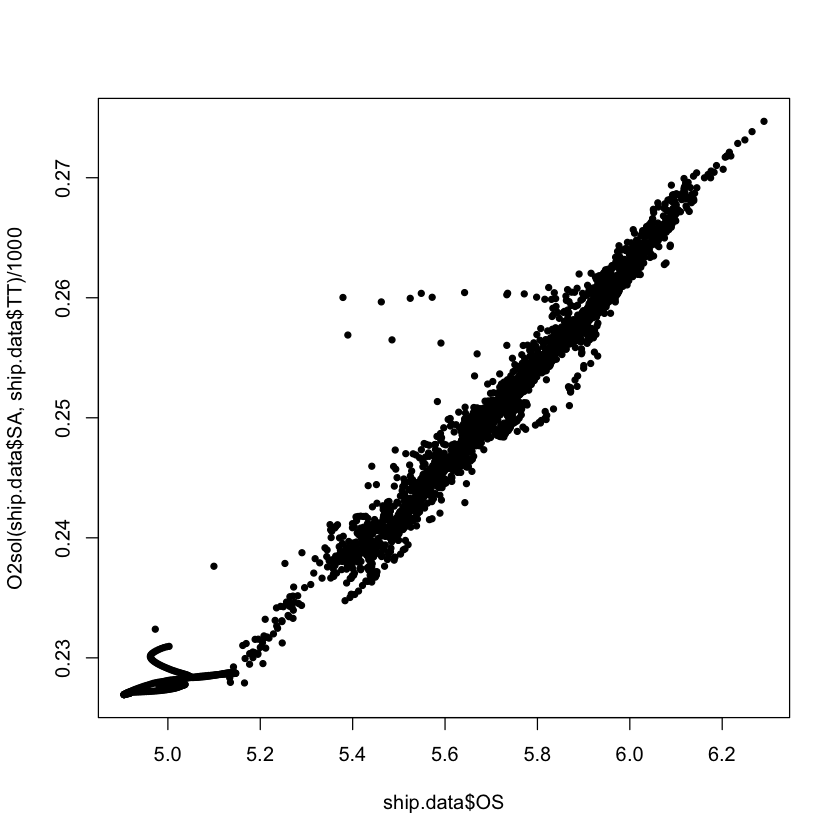

In [20]:
plot(ship.data$OS, O2sol(ship.data$SA, ship.data$TT)/1000, pch=20)

[1] 274.6098

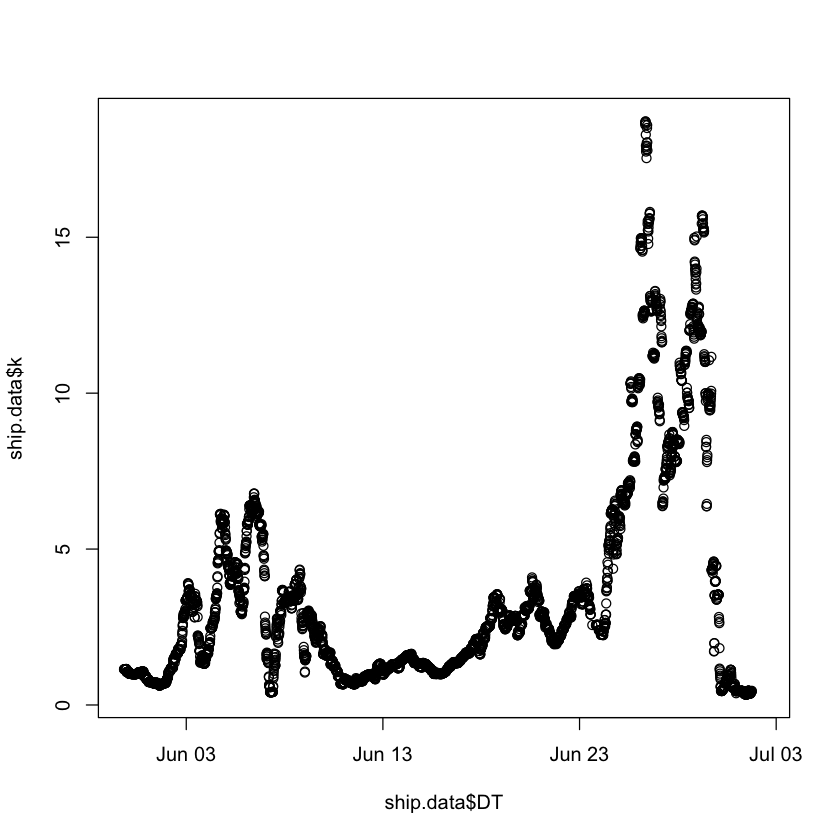

In [21]:
O2sol()
plot(ship.data$DT, ship.data$k)

In [9]:
#### Calcualtes density from S and T (Massel 2015)
rho = function(S=30, T=15, p=0) {
    a.0 = 999.842594
    a.1 = 6.793953e-2
    a.2 = -9.095290e-3
    a.3 = 1.001685e-4
    a.4 = -1.120083e-6
    a.5 = 6.536332e-9
    rho.smow = a.0 + a.1*T + a.2*T^2 + a.3*T^3 + a.4*T^4 + a.5*T^5
    
    b.0 = 8.2449e-1
    b.1 = -4.0899e-3
    b.2 = 7.6438e-5
    b.3 = -8.2467e-7
    b.4 = 5.3875e-9
    B.1 = b.0 + b.1*T + b.2*T^2 + b.3*T^3 + b.4*T^4
    
    c.0 = -5.7246e-3
    c.1 = 1.0227e-4
    c.2 = -1.6546e-6
    d.0 = 4.8314e-4
    C.1 = c.0 + c.1*T + c.2*T^2
    
    rho = rho.smow + B.1 * S + C.1 * S^1.5 + d.0 * S^2
    rho
}

In [10]:
summary(ship.data$k)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.3307  1.1830  2.4140  3.4600  3.7870 18.7200      89 

# NCP Calculation

In [11]:
# NCP in mmol O2 m-2 d-1; seawater density in kg m-3, O2sol in microL kg-1
#ncp = (ship.data$O2.Ar/100) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * ship.data$sw_dens0(salt, temp) * wpv;

ship.data$NCP = 0
ship.data$NCP = (ship.data$O2.Ar/ship.data$O2.Ar.cal - 1) *
    O2sol(ship.data$SA, ship.data$TT)/1000 * # mmol / kg
    rho(S = ship.data$SA, ship.data$TT) *
    ship.data$k

ship.data = ship.data[!is.na(ship.data$NCP),]

# Preliminary Review

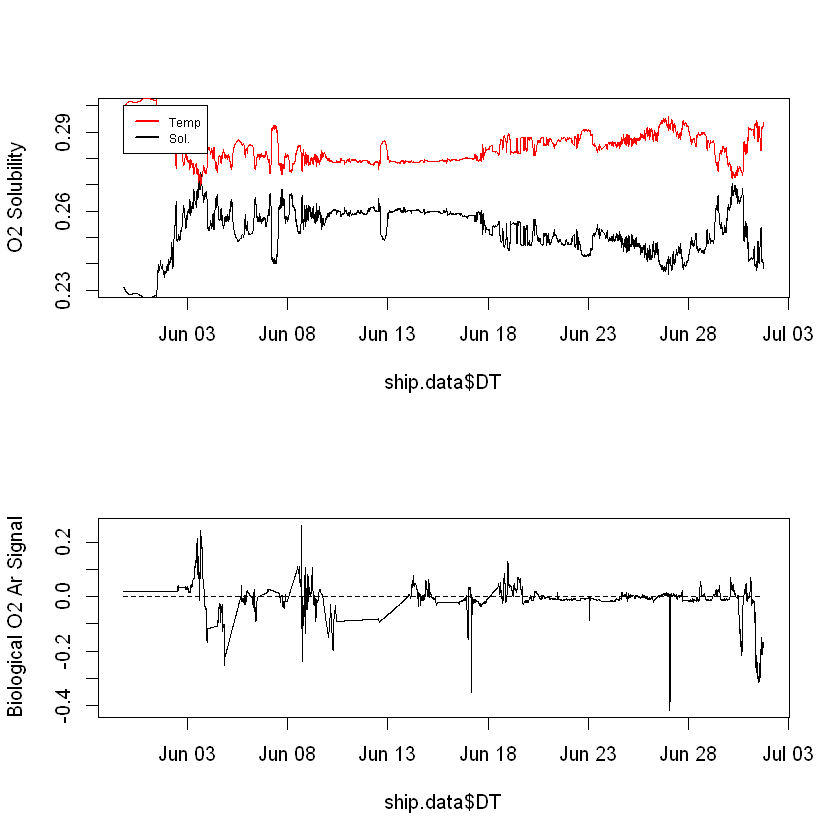

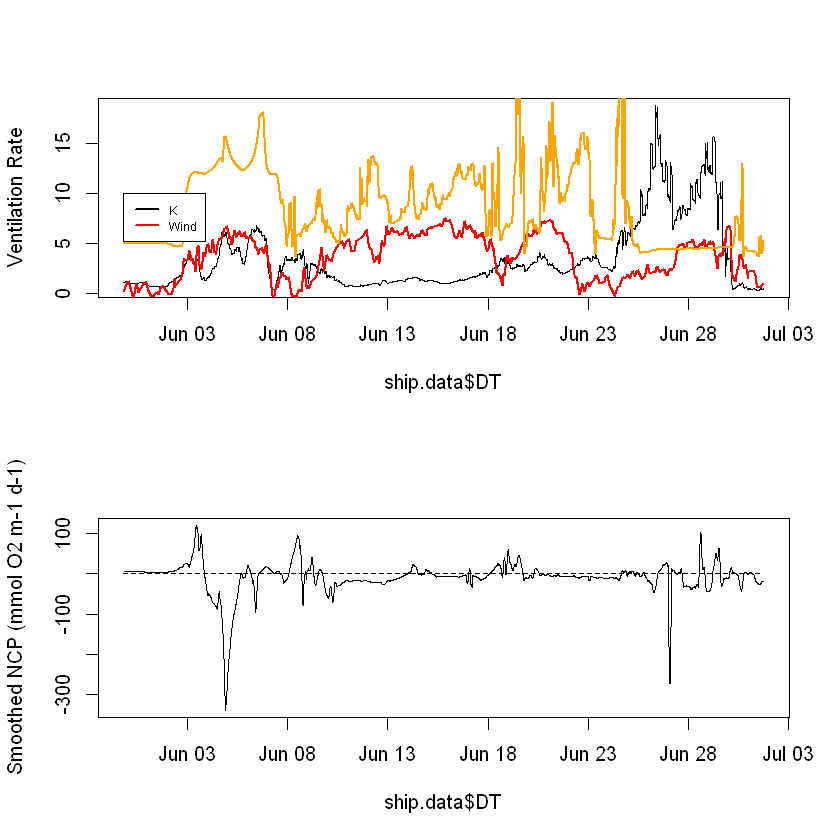

In [28]:
#pdf('Output/NCP Diagnostics.pdf')

par(mfrow=c(2,1))

## O2 solubility and temperature
plot(ship.data$DT, O2sol(ship.data$SA, ship.data$TT) / 1000, type='l', ylab='O2 Solubility', ylim=c(0.23, 0.30))
lines(ship.data$DT, ship.data$TT/300 + 0.235, col='red', lwd=1)
legend(ship.data$DT[1], 0.30, c('Temp', 'Sol.'), col=c('red', 'black'), cex=0.6, lwd=2)

## Biological O2 argon singal
plot(ship.data$DT,  (ship.data$O2.Ar / ship.data$O2.Ar.cal - 1), type='l', ylab='Biological O2 Ar Signal')
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)

## Wind speed and k values
plot(ship.data$DT, ship.data$k, type='l', ylab='Ventilation Rate')
lines(ship.data$DT, ship.data$NCEP/2, col='red', lwd=2)
lines(ship.data$DT, ship.data$MLD/3, col='orange', lwd=2)
legend(ship.data$DT[1], 10, c('K', 'Wind'), col=c('black', 'red'), cex=0.6, lwd=2)

## NCP plot (smoothed)
plot(ship.data$DT, ma(ship.data$NCP, 15), type='l', ylab='Smoothed NCP (mmol O2 m-1 d-1)')
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)
## lines(ship.data$DT,  O2sol(ship.data$SA, ship.data$TT) - ship.data$OS) ## TODO: COnvert ship O2 to useable units
#lines(ship.data$DT, (rho(S = ship.data$SA, ship.data$TT)*10 - 10400), col='red', lwd=2)
#legend(ship.data$DT[1], -100, c('NCP', 'Rho'), col=c('black', 'red'), cex=0.6, lwd=2)

## NCP plot (smoothed)
#plot(ship.data$DT, rho(S = ship.data$SA, ship.data$TT), type='l', ylab='Density (Kg m-3)')

#dev.off()

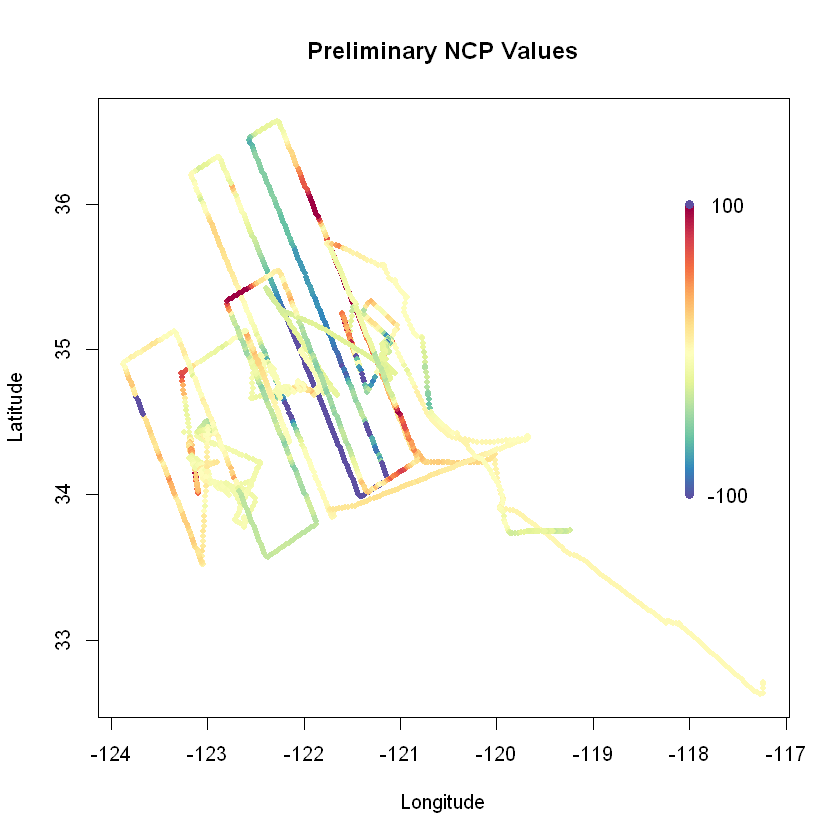

In [25]:
#pdf('Output/Spatial NCP.pdf')

#This adds a column of color values
# based on the y values
ncp2 = ship.data$NCP
ncp2[ncp2 < -100] = -100
ncp2[ncp2 > 100] = 100

#col <- get.pal(ncp2)
col = make.div.pal(ncp2, 100)

plot(ship.data$LO, ship.data$LA, pch = 20, col = col, main='Preliminary NCP Values', ylab='Latitude', xlab='Longitude')

## Legend
points(x = rep(-118, 101), y = seq(34, 36, 1/50), col=get.div.pal(100), pch=16)
text(-117.6, 36, paste0(floor(max(ncp2))))
text(-117.6, 34, paste0(floor(min(ncp2))))

#dev.off()

In [26]:
save(ship.data, file='./RStates/ship.ncp.rdata')
write.xlsx(ship.data, file='./Input Data/Shipdata - NCP.xlsx')

# Cycles Analysis

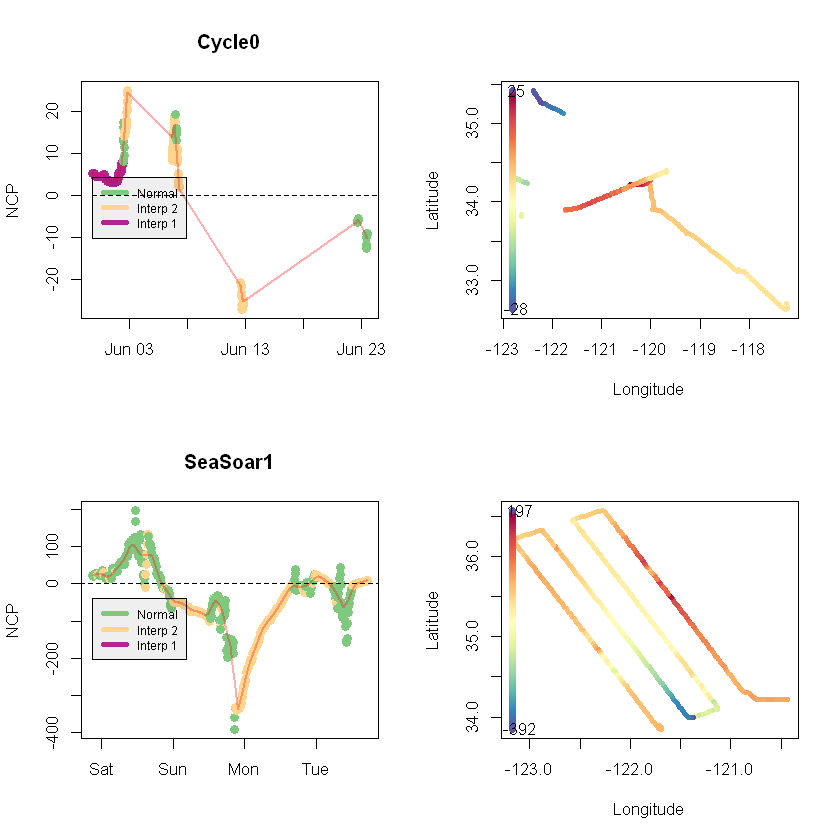

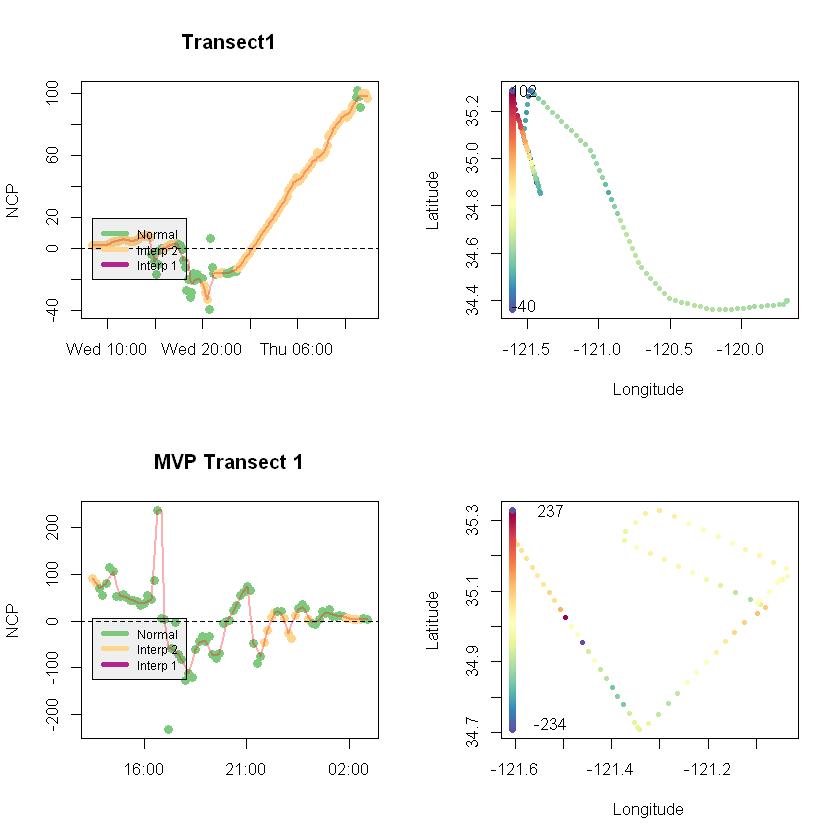

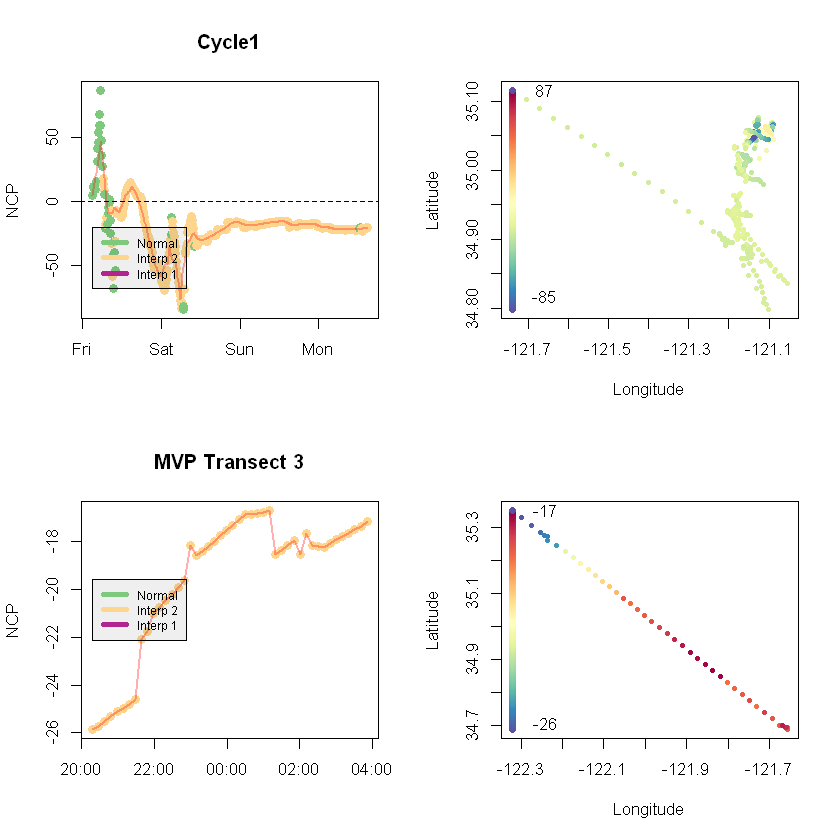

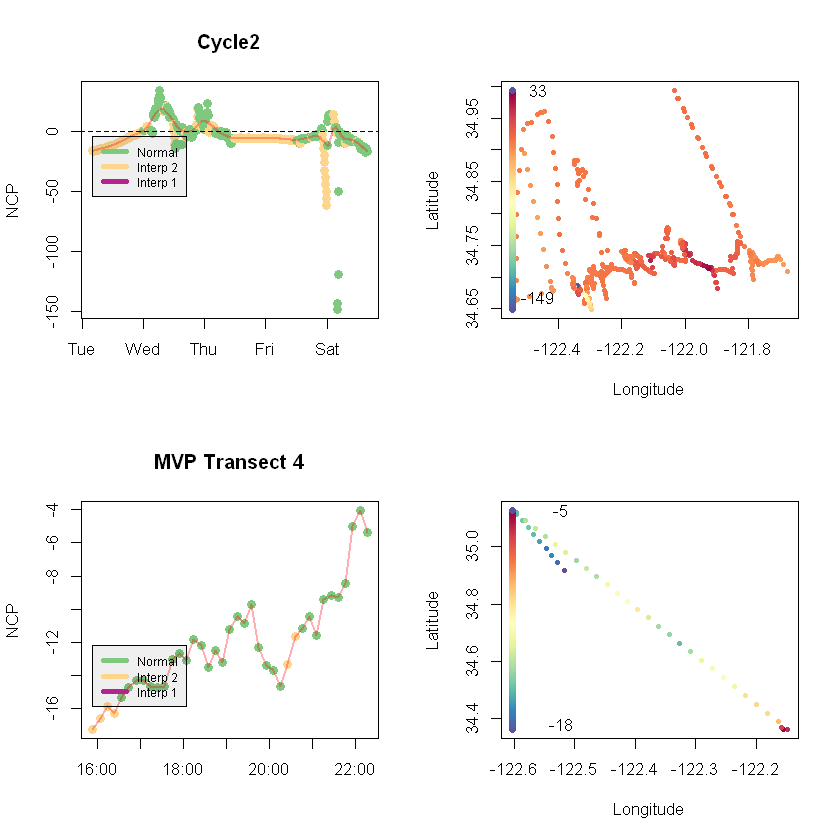

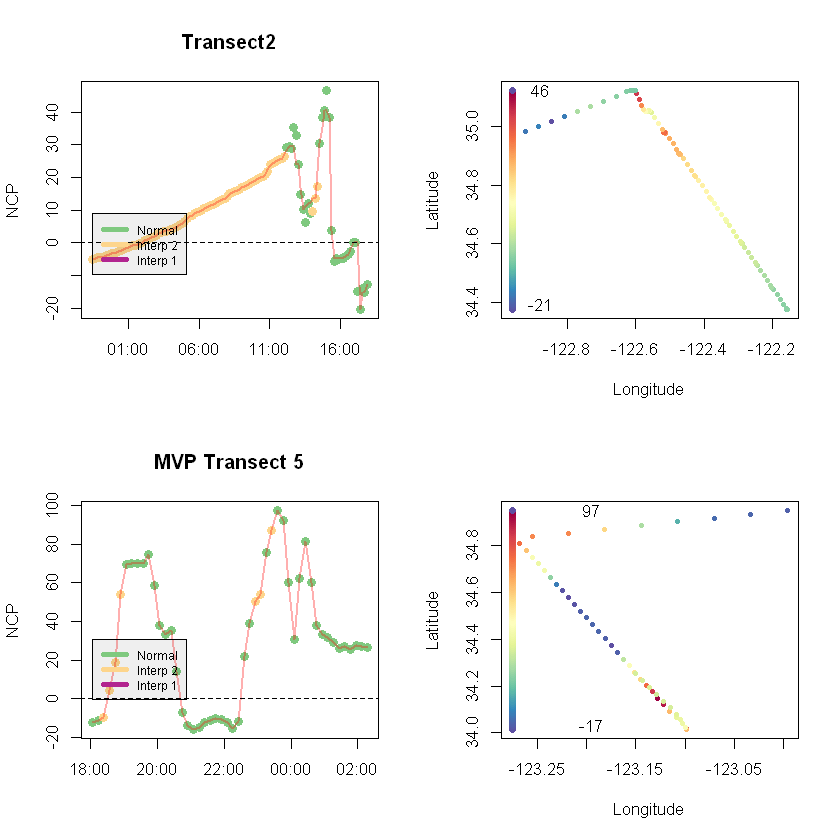

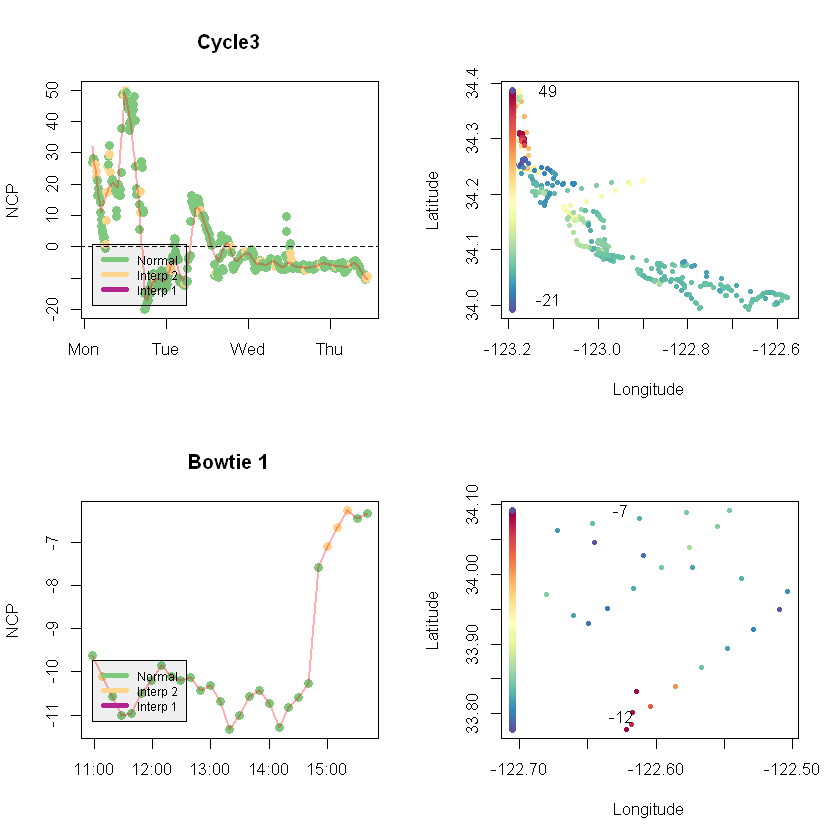

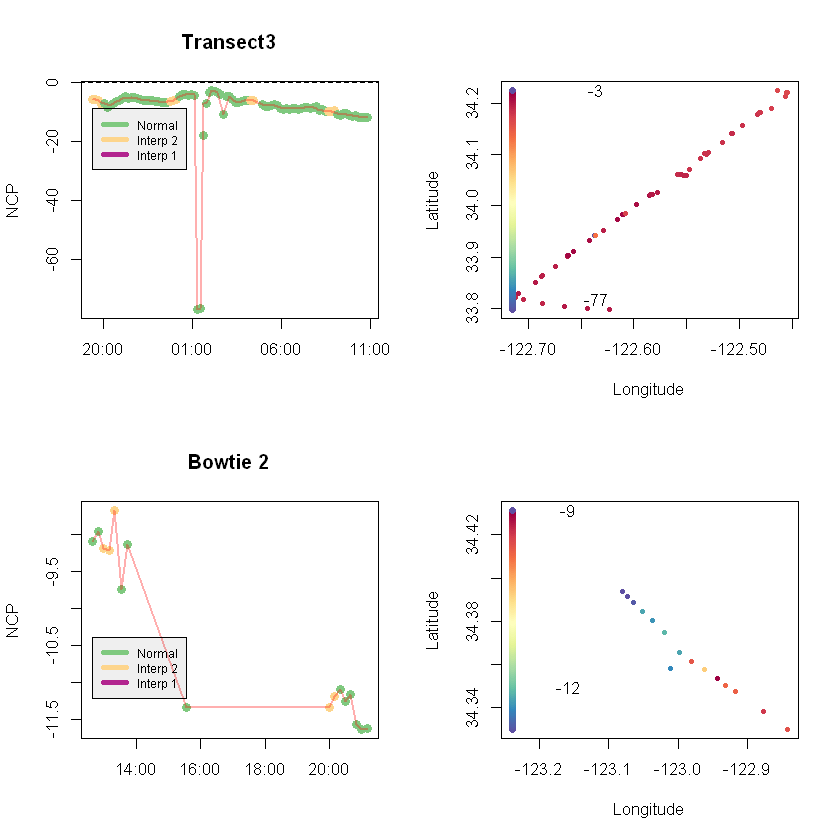

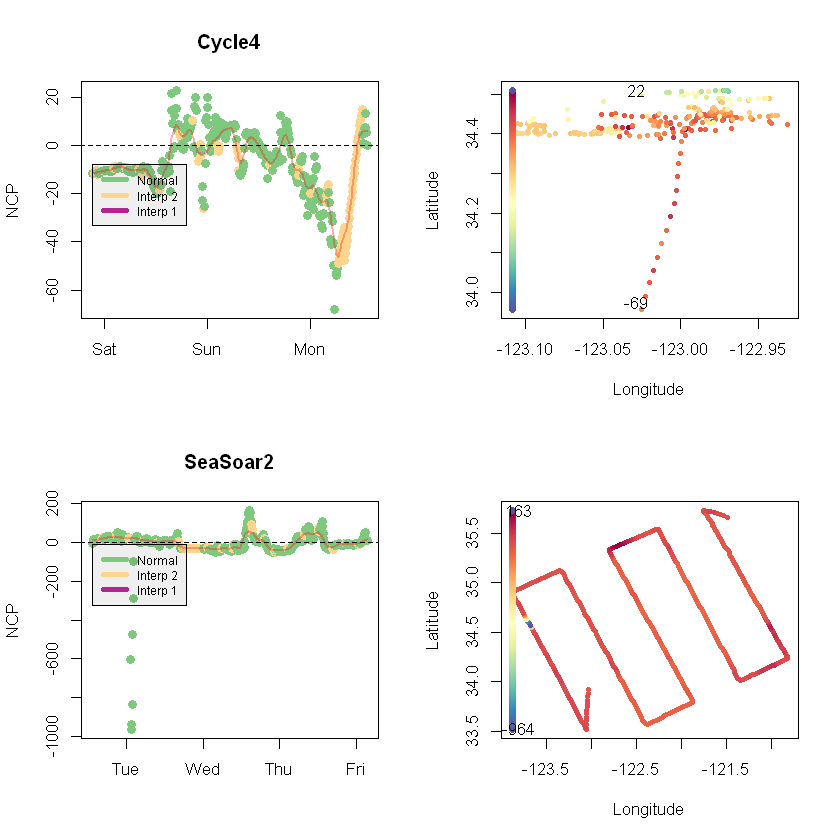

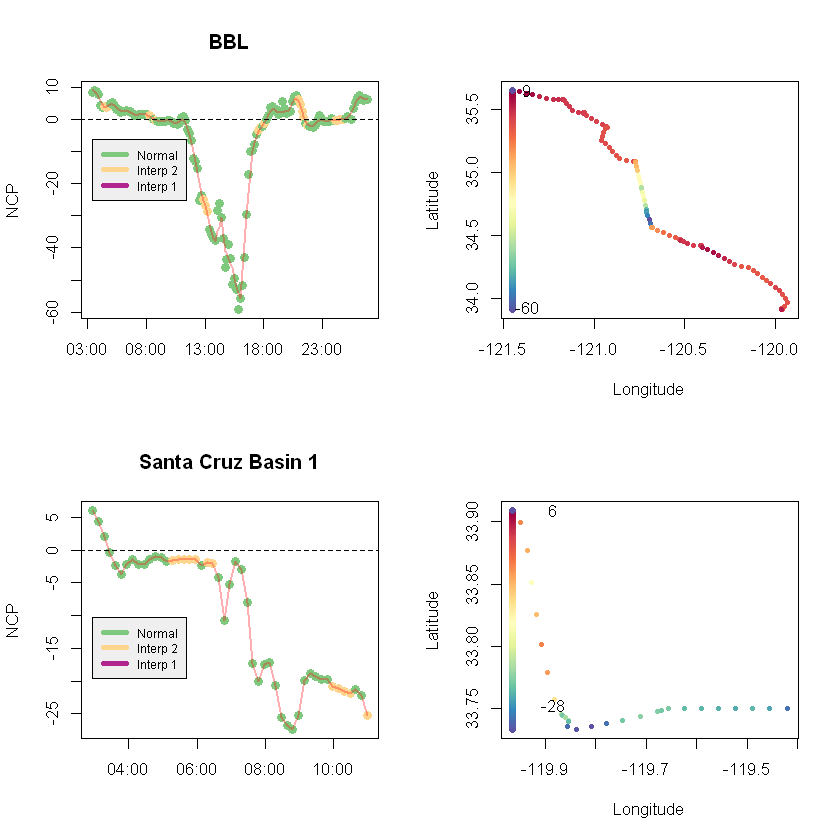

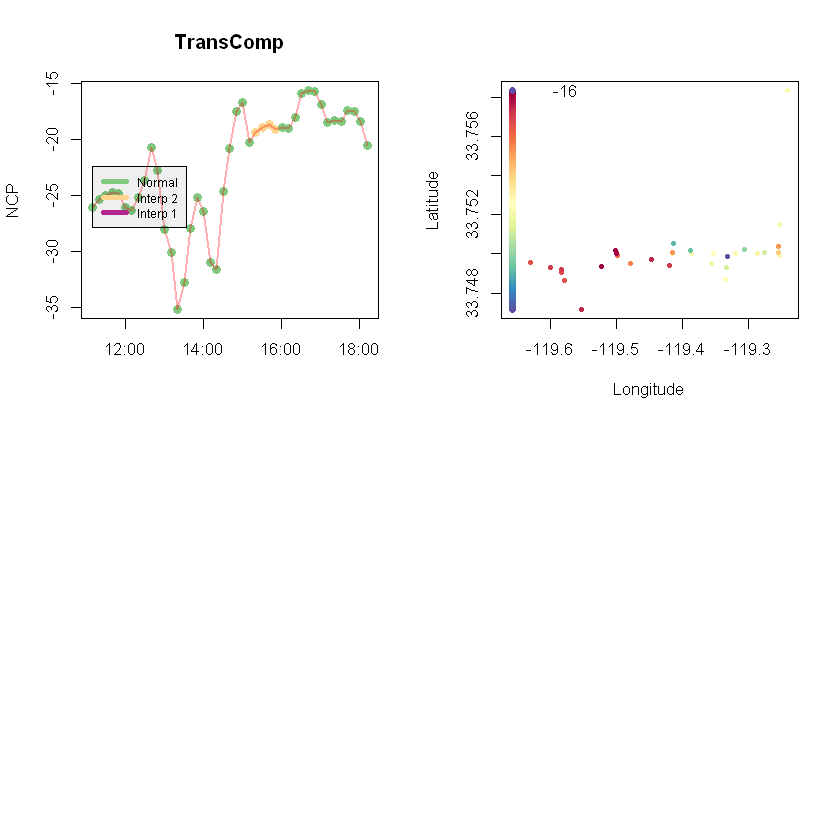

In [27]:
#pdf('Output/NCP Cycles Preliminary.pdf')
par(mfrow=c(2,2))

for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    
    ## Set colors
    col = make.div.pal(ship.data$NCP[l], 100)
    flag.col = get.qual.pal(n = 4)
    
    ##########################
    ## Plot the Timesseries ##
    ##########################
    plot(ship.data$DT[l], ship.data$NCP[l], main=i, pch=16, cex=1.2, lwd=2,
         ylab='NCP', xlab='', col=flag.col[ship.data$FLAG.O2.Ar[l]])
    
    ## Add trendline and legend
    mod = lowess(x = ship.data$DT[l], ship.data$NCP[l], f = 0.05)
    lines(mod, col='#ff000050', lwd=2)
    lines(x=c(min(ship.data$DT), max(ship.data$DT)), y= c(0, 0), lty=2) # Zero line
    legend(ship.data$DT[l[1]], mean(ship.data$NCP[l]), c('Normal', 'Interp 2', 'Interp 1'),
           col=flag.col[1:3], cex=0.7, lwd=4, bg='#00000010')
    
    
    #########################
    ## Plot Spatial Extent ##
    #########################
    plot(ship.data$LO[l], ship.data$LA[l], pch=20, col=col, ylab='Latitude', xlab='Longitude')
    points(x = rep(min(ship.data$LO[l]), 101), y = seq(min(ship.data$LA[l]), max(ship.data$LA[l]), length.out=101),
           col=get.div.pal(100), pch=16)
    text(min(ship.data$LO[l])+0.08, max(ship.data$LA[l]), floor(max(ship.data$NCP[l])))
    text(min(ship.data$LO[l])+0.08, min(ship.data$LA[l])+0.02, floor(min(ship.data$NCP[l])))
}
#dev.off()

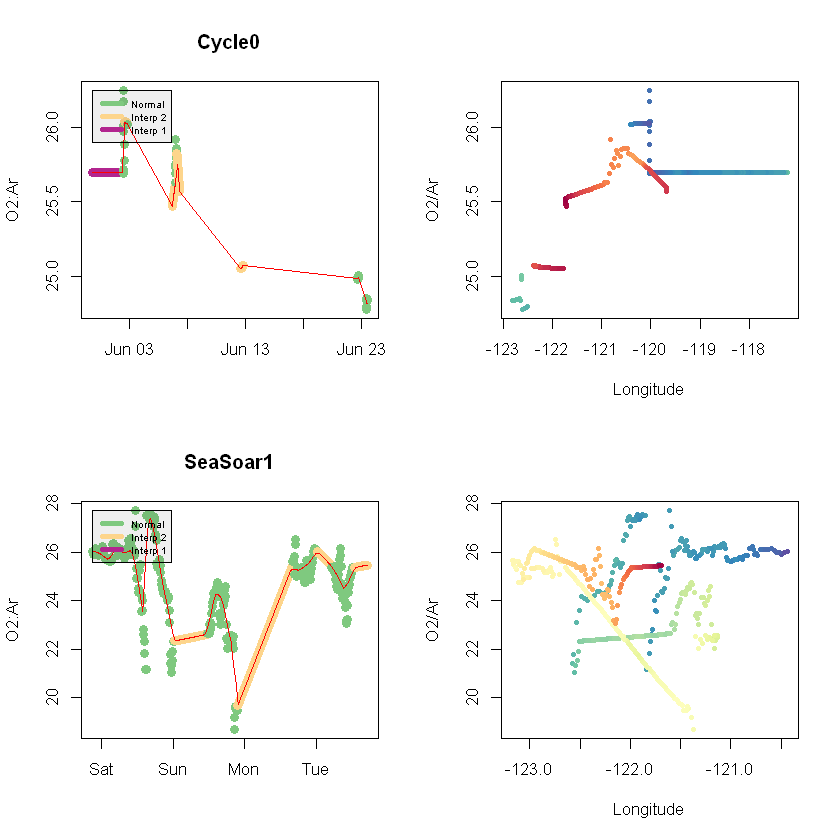

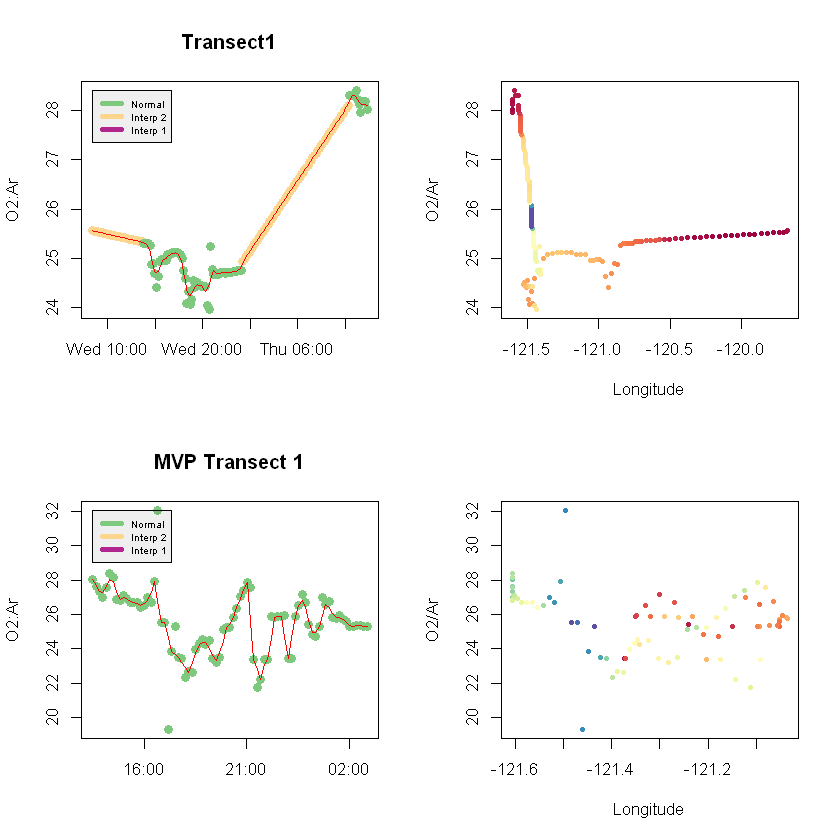

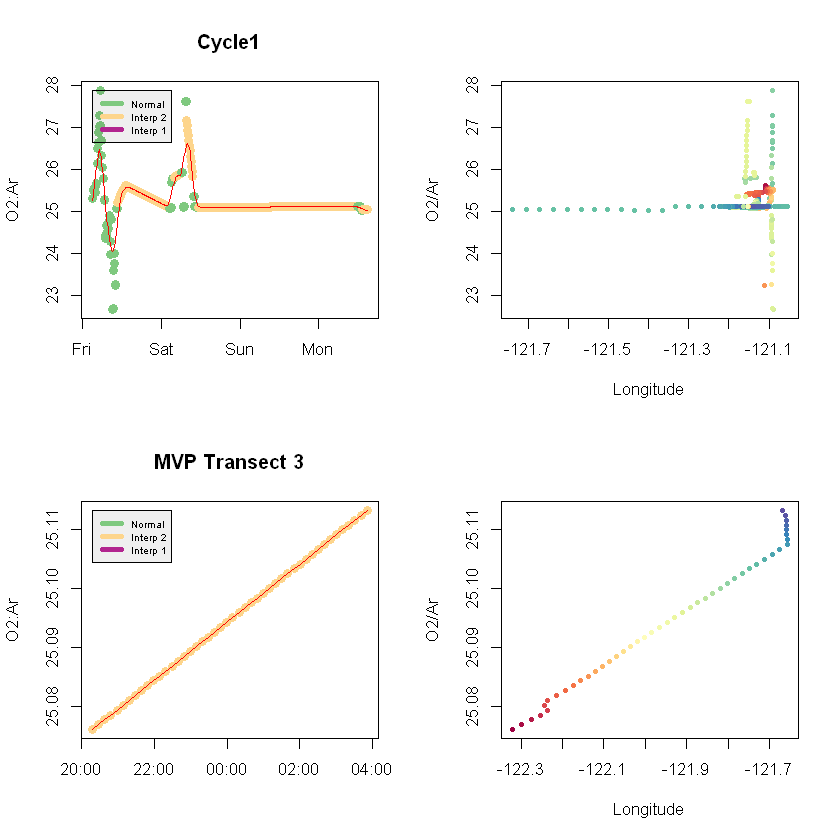

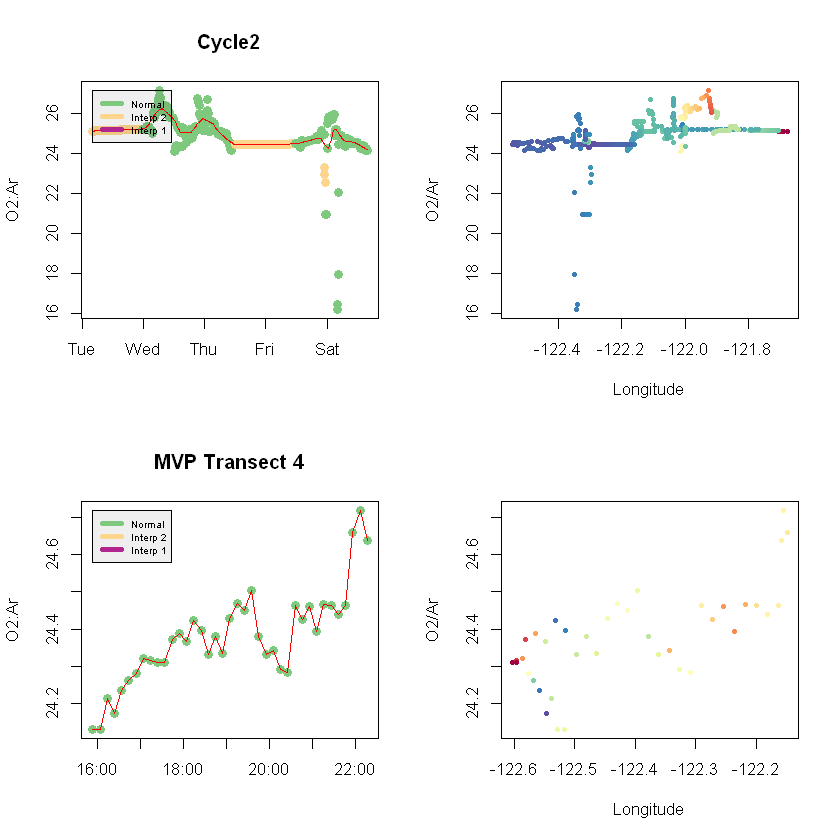

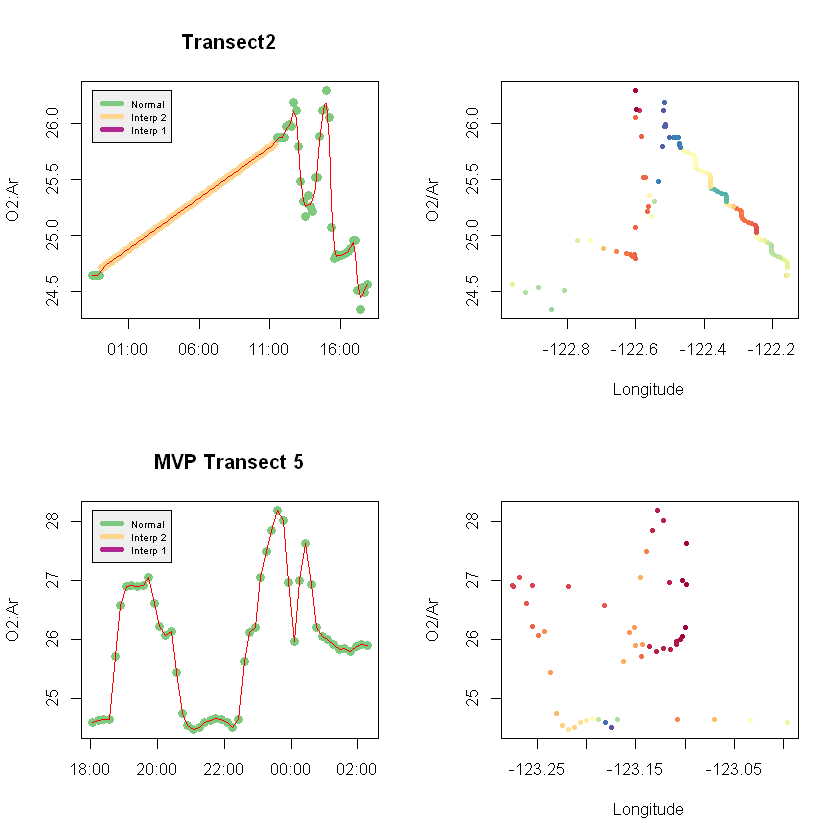

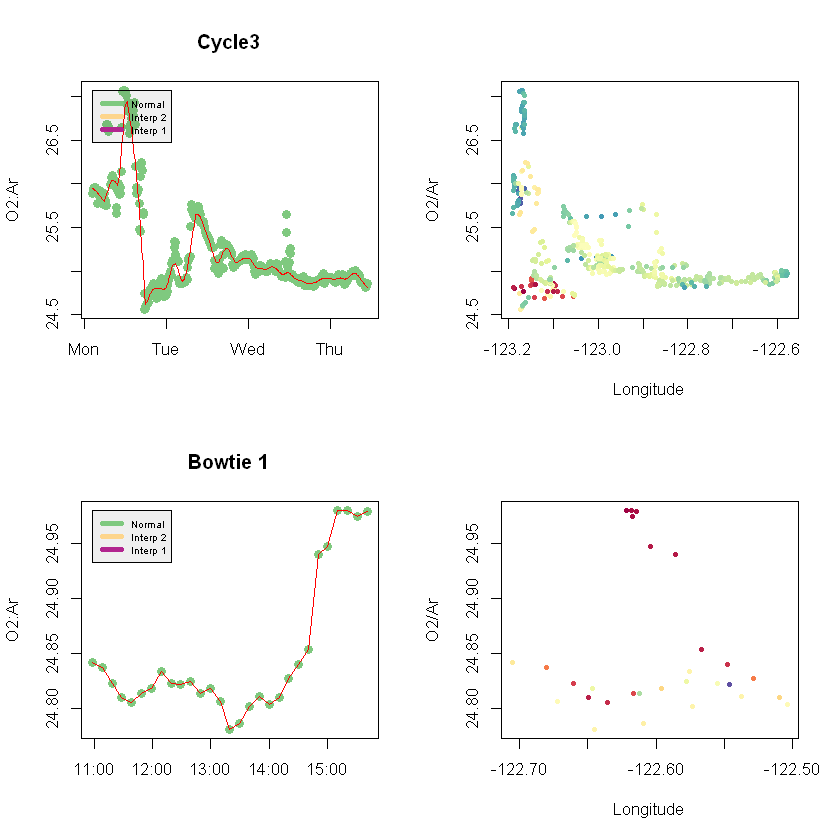

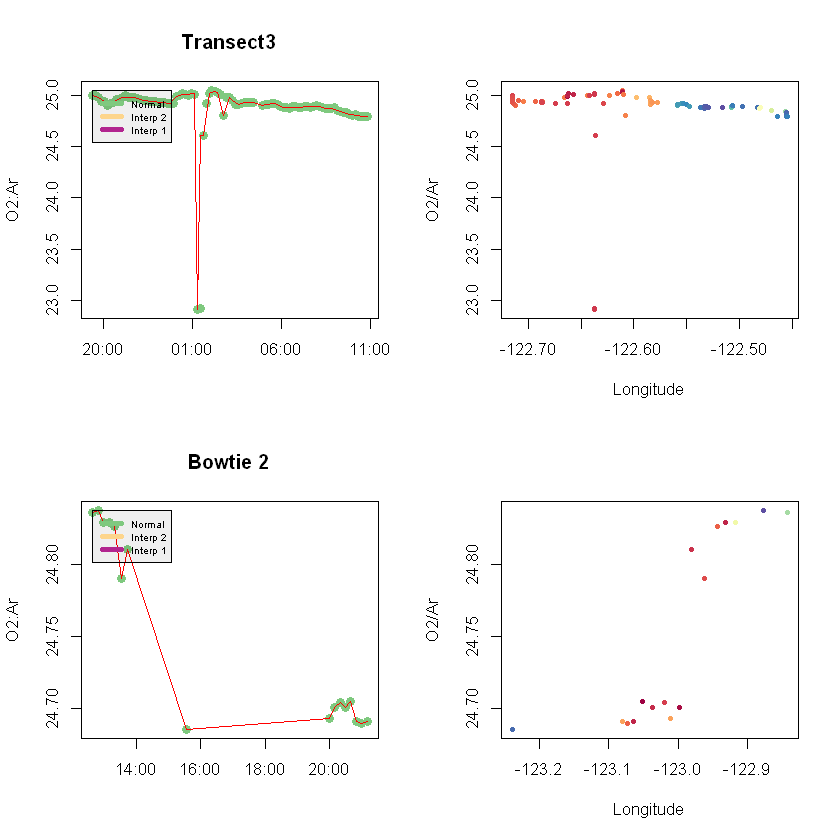

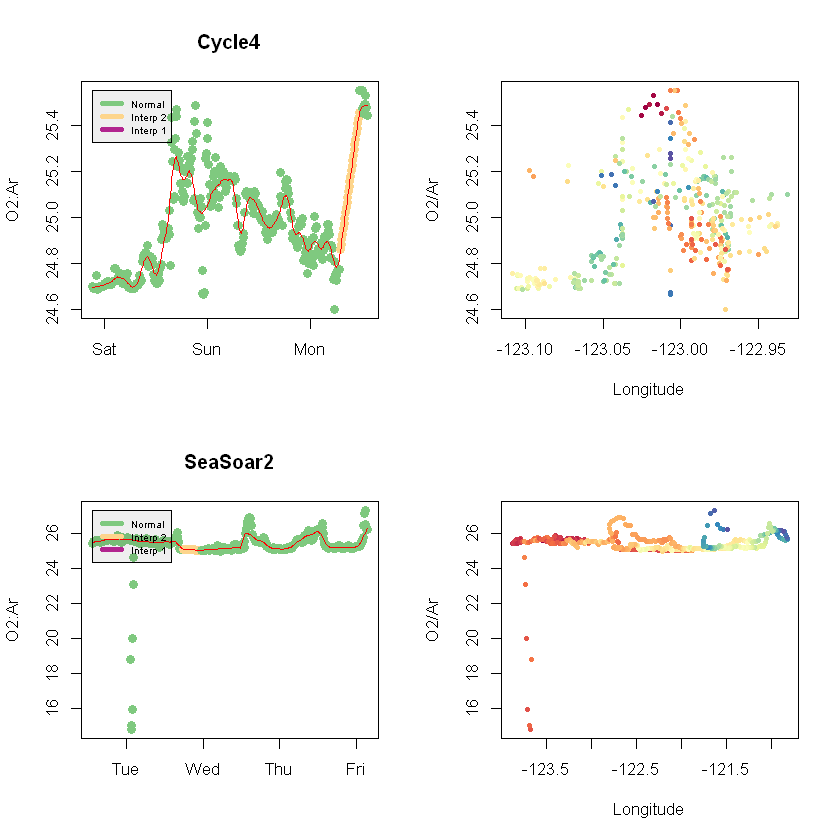

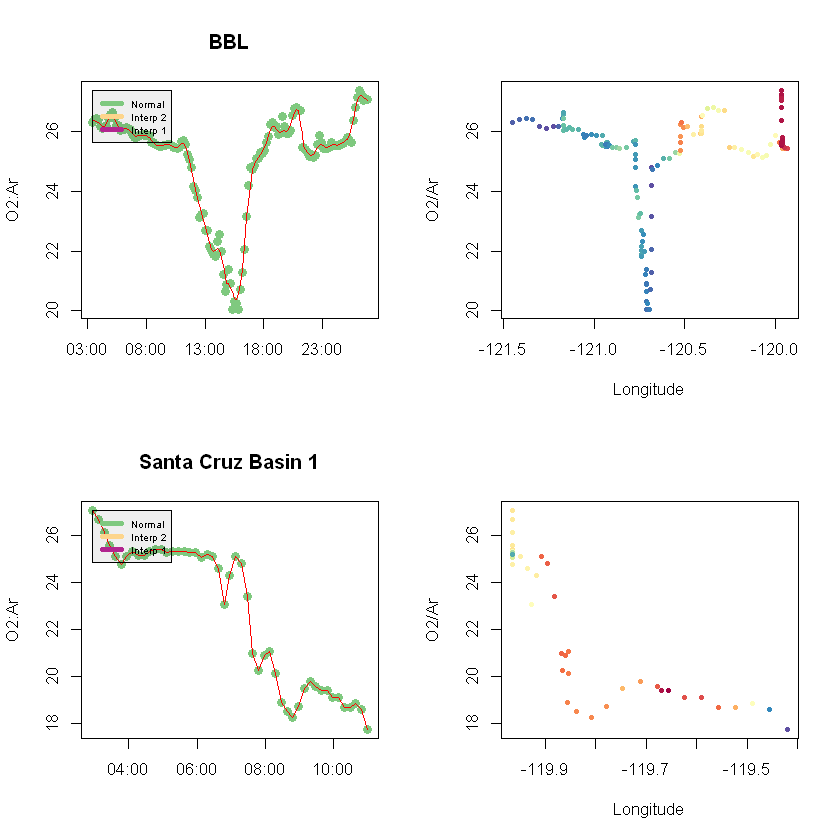

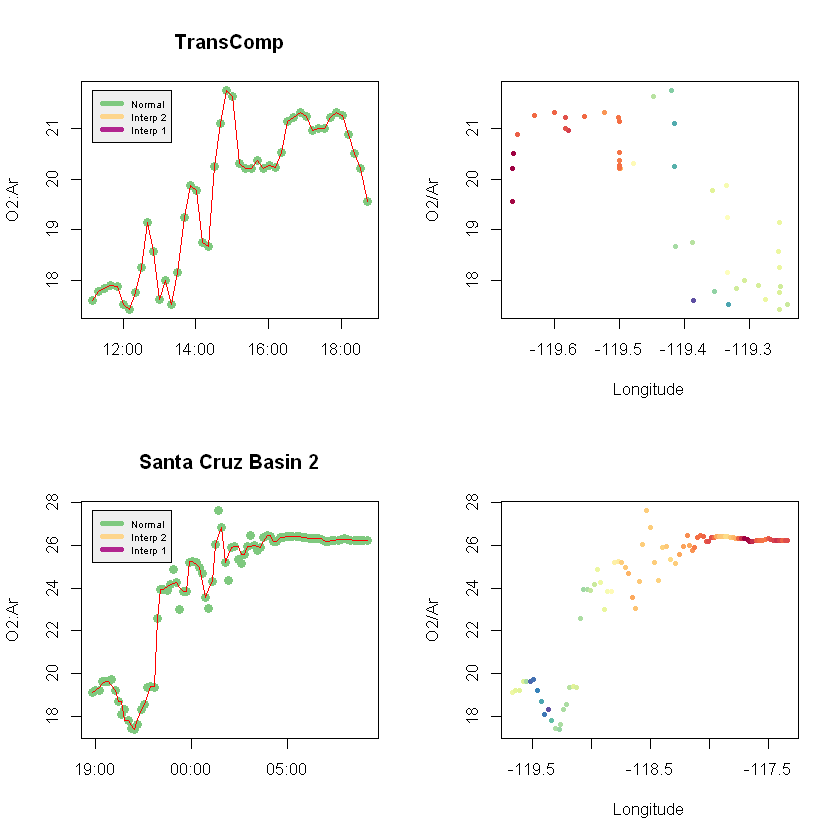

In [257]:
#pdf('Output/NCP Cycles Preliminary pt2.pdf')
par(mfrow=c(2,2))

for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    #l = l[ship.data$NCP[l] > -10000 & ship.data$NCP[l] < 10000]
    
    ## Set colors
    col = make.div.pal(ship.data$k[l], 100)
    flag.col = get.qual.pal(4)
    
    ######################
    ## Plot Time series ##
    ######################
    plot(ship.data$DT[l], ship.data$O2.Ar[l], main=i, pch=16, cex=1.2, lwd=2, ylab='O2:Ar', xlab='',
        col=flag.col[ship.data$FLAG.O2.Ar[l]])
    
    ## Add trendline and legend
    mod = lowess(x = ship.data$DT[l], ship.data$O2.Ar[l], f = 0.05)
    lines(mod, col='#ff0000', lwd=1)
    legend(ship.data$DT[l[1]], max(ship.data$O2.Ar[l]), c('Normal', 'Interp 2', 'Interp 1'),
           col=flag.col[1:3], cex=0.6, lwd=4, bg='#00000010')
    
    ##################
    ## Spatial Plot ##
    ##################
    plot(ship.data$LO[l], ship.data$O2.Ar[l], pch=20, col=col, ylab='O2/Ar', xlab='Longitude')
}
#dev.off()

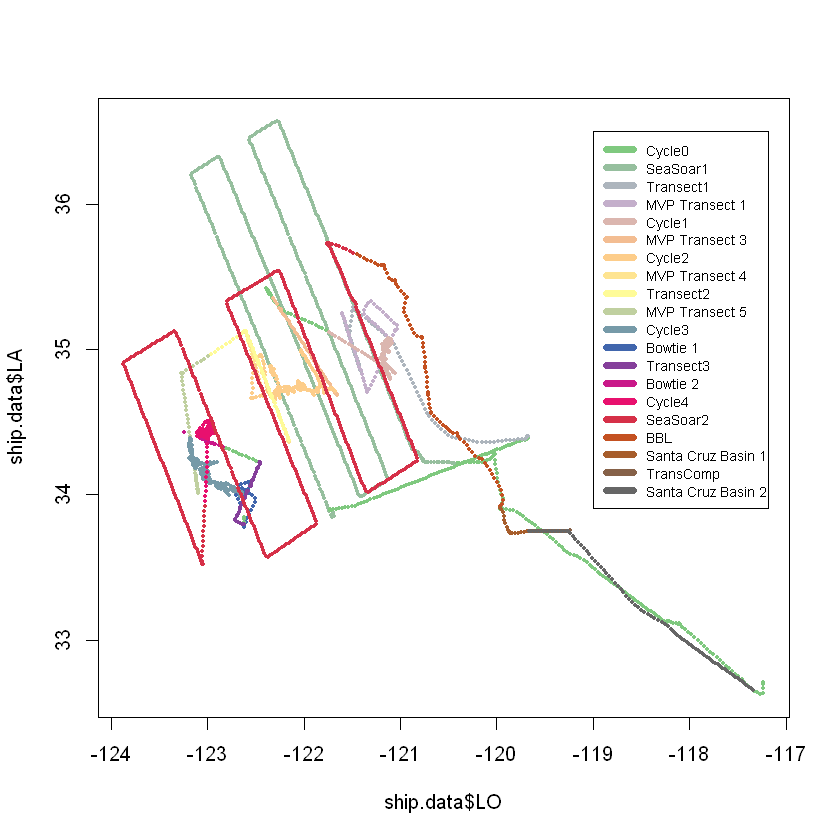

In [247]:
col = get.qual.pal(length(unique(ship.data$Cycle)))
cols = sapply(ship.data$Cycle, function(x) {which(unique(ship.data$Cycle) == x)})

plot(ship.data$LO, ship.data$LA, col=col[cols], cex=0.7, pch=20)

legend(-119, 36.5, c(unique(ship.data$Cycle)), col=col[unique(cols)], lwd=6, cex=0.7)

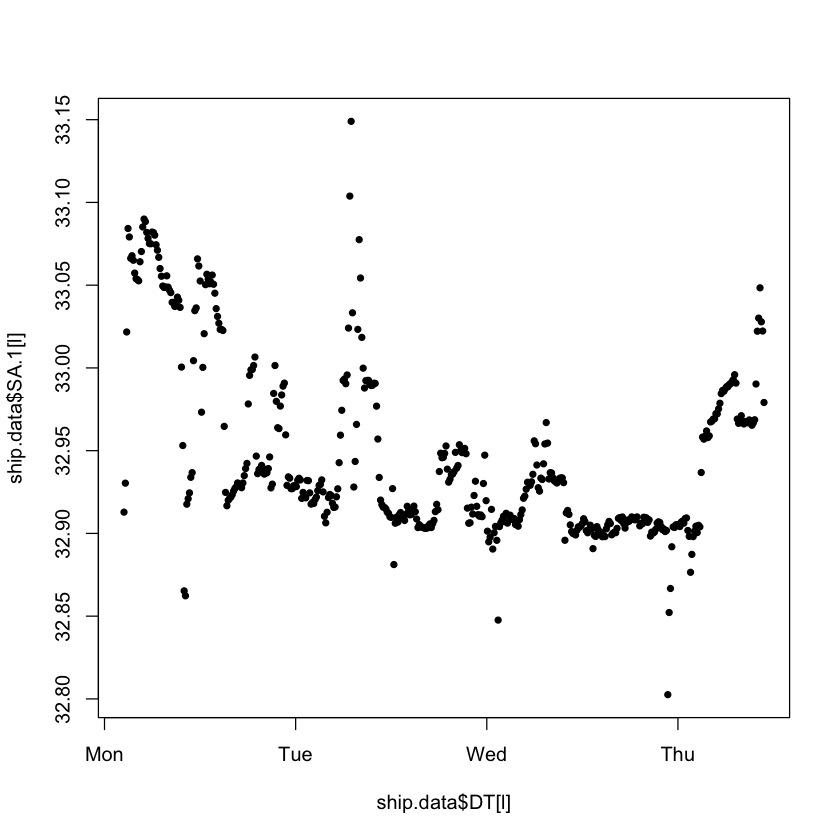

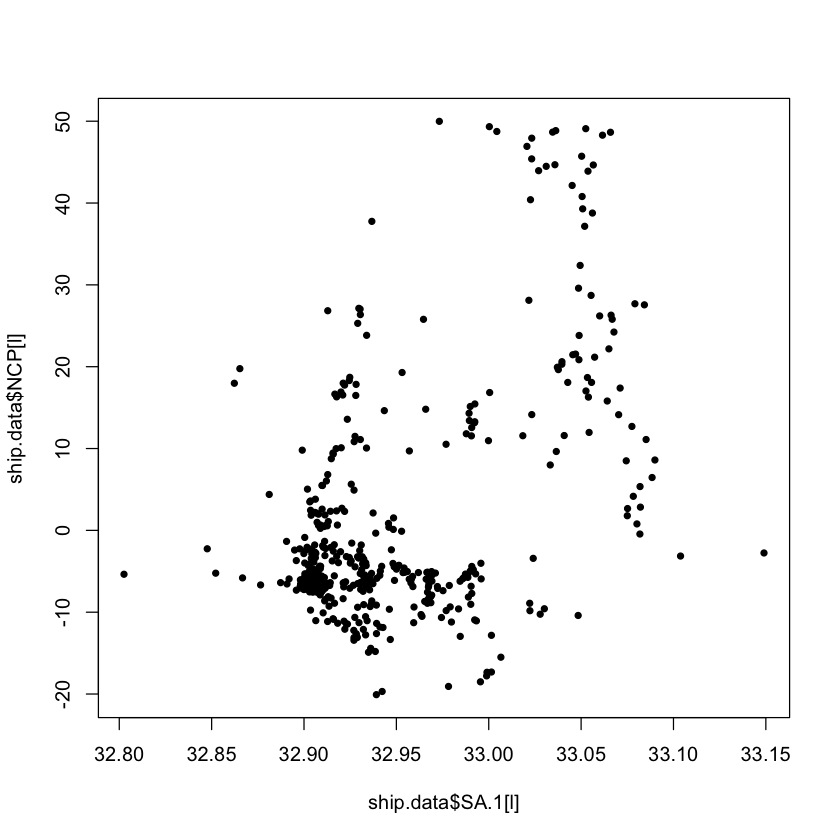

In [14]:
l = which(ship.data$Cycle == "Cycle3")

plot(ship.data$DT[l], ship.data$SA.1[l], pch=20)

plot(ship.data$SA.1[l], ship.data$NCP[l], pch=20)